# Gradient Class Activation Map (GRAD-CAM)
#### Cats vs Dogs Image Classifier

In [1]:
!pip install tf_explain

import cv2 
import tensorflow as tf
from tensorflow.python import keras
import numpy as np
import matplotlib.pyplot as plt
from tf_explain.core.grad_cam import GradCAM

import os
import glob
import random

In [ ]:
from kaggle.api.kaggle_api_extended import KaggleApi

os.environ['KAGGLE_USERNAME'] = "gerardoguzman"                 #Manually input from kaggle
os.environ['KAGGLE_KEY'] = "3709fce2d23a68367de1f83b74836f33"   #Manually input from kaggle

api = KaggleApi()
api.authenticate()

api.dataset_download_files('d4rklucif3r/cat-and-dogs', path="./Images/", unzip=True)
del api

In [2]:
paths = ["Images/dataset/training_set/", "Images/dataset/test_set/"]
classes = ['cats', 'dogs']

In [3]:
data = []

for i,path in enumerate(paths):
    for label_int, label_str in enumerate(classes):
        for filename in glob.glob(path + label_str + '/*.jpg'):
            img = cv2.imread(filename)
            data.append([label_int, cv2.resize(img,(200,200)) ])
print("Number of elements: {}".format(len(data)))

Number of elements: 10000


#### Division of the dataset into Training(80%), Validation(10%) and Testing(10%)

In [4]:
X_train , Y_train = [],[]
X_val , Y_val = [],[]
X_test , Y_test = [],[]

#Shuffle the data list everytime with the same seed
random.Random(0).shuffle(data)

for i, sample in enumerate(data):
    label, img = sample
    
    if i <= 0.8*len(data):
        X_train.append(img)
        Y_train.append(label)
    elif i > 0.8*len(data) and i < 0.9*len(data):
        X_val.append(img)
        Y_val.append(label)
    else:
        X_test.append(img)
        Y_test.append(label)


X_train = np.array(X_train)
X_val = np.array(X_train)
X_test = np.array(X_train)

Y_train = np.array(Y_train)
Y_val = np.array(Y_train)
Y_test = np.array(Y_train)

del data

#### OneHot encoding

In [5]:
Y_train_onehot = tf.one_hot(Y_train, len(classes))
Y_val_onehot = tf.one_hot(Y_val, len(classes))
Y_test_onehot = tf.one_hot(Y_test, len(classes))

#### CNN Implementation

In [6]:
from keras.models import Sequential
from keras.layers import Convolution2D, Flatten, MaxPooling2D, Dense

In [7]:
model = Sequential([
   Convolution2D(30, (3,3), input_shape=(200,200,3), activation = 'relu'),
   MaxPooling2D(pool_size=(2,2)),
   Convolution2D(25, (3,3), activation = 'relu'),
   Convolution2D(20, (3,3), activation = 'relu'),
   MaxPooling2D(pool_size=(2,2)),
   Convolution2D(18, (3,3), activation = 'relu'),
   Convolution2D(14, (3,3), activation = 'relu'),
   MaxPooling2D(pool_size=(2,2)),
   Flatten(),
   Dense(25, activation='relu'),
   Dense(2, activation='softmax')
])

model.compile(optimizer="adamax", loss="categorical_crossentropy", metrics=['accuracy'])
model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d (Conv2D)             (None, 198, 198, 30)      840       
                                                                 
 max_pooling2d (MaxPooling2D  (None, 99, 99, 30)       0         
 )                                                               
                                                                 
 conv2d_1 (Conv2D)           (None, 97, 97, 25)        6775      
                                                                 
 conv2d_2 (Conv2D)           (None, 95, 95, 20)        4520      
                                                                 
 max_pooling2d_1 (MaxPooling  (None, 47, 47, 20)       0         
 2D)                                                             
                                                                 
 conv2d_3 (Conv2D)           (None, 45, 45, 18)        3

In [8]:
from keras.callbacks import TensorBoard, ModelCheckpoint

chekpoint = ModelCheckpoint('Check_point/model.{epoch:d}.h5', save_best_only=False, save_freq='epoch')
tensorboard_cbck = TensorBoard('Logs/cnn_logs', histogram_freq=1)

In [9]:
#Train model
epoch = 15

model.fit(X_train, Y_train_onehot,epochs=epoch,batch_size=100,
            validation_data=[X_val, Y_val_onehot], callbacks=[tensorboard_cbck,chekpoint],  verbose=1)

Epoch 1/15
67/67 [==============================] - 10s 109ms/step - loss: 1.8654 - accuracy: 0.5116 - val_loss: 0.6824 - val_accuracy: 0.5577
Epoch 2/15
67/67 [==============================] - 6s 97ms/step - loss: 0.6750 - accuracy: 0.5666 - val_loss: 0.6635 - val_accuracy: 0.5966
Epoch 3/15
67/67 [==============================] - 6s 97ms/step - loss: 0.6514 - accuracy: 0.6068 - val_loss: 0.6366 - val_accuracy: 0.6352
Epoch 4/15
67/67 [==============================] - 6s 96ms/step - loss: 0.6262 - accuracy: 0.6459 - val_loss: 0.6176 - val_accuracy: 0.6403
Epoch 5/15
67/67 [==============================] - 6s 97ms/step - loss: 0.6003 - accuracy: 0.6733 - val_loss: 0.5730 - val_accuracy: 0.7013
Epoch 6/15
67/67 [==============================] - 6s 96ms/step - loss: 0.5692 - accuracy: 0.6963 - val_loss: 0.5459 - val_accuracy: 0.7214
Epoch 7/15
67/67 [==============================] - 6s 97ms/step - loss: 0.5447 - accuracy: 0.7210 - val_loss: 0.5229 - val_accuracy: 0.7367
Epoch 8/15


##### Tensorboard for choosing the best model

In [ ]:
#load_ext tensorboard
#%tensorboard --logdir ./Logs/ 

## GRAD-CAM

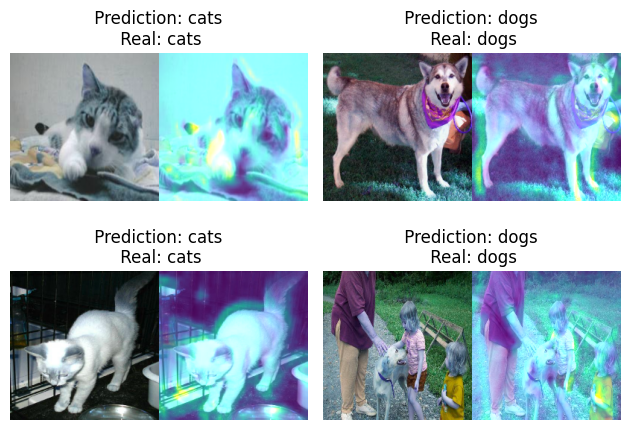

In [11]:
fig, axs = plt.subplots(2, 2)

for i in range(2):
    for j in range(2):
        rand_img = random.randint(0,X_test.shape[0])

        data = ([X_test[rand_img]], None)

        predict_class_index = np.argmax(model.predict( np.array([X_test[rand_img]]) , verbose = 0))
        explainer = GradCAM()

        heat_map = explainer.explain(data, model, class_index=predict_class_index, layer_name="conv2d_3")
        #heat_map = (heat_map - np.min(heat_map)) / (heat_map.max() - heat_map.min())


        axs[i][j].imshow( np.concatenate((X_test[rand_img], heat_map), axis = 1))
        axs[i][j].set_title(" Prediction: {} \n Real: {}".format(classes[predict_class_index], classes[Y_test[rand_img]]))
        axs[i][j].axis('off')
plt.tight_layout()
plt.show()